**Import Important Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.util import ngrams
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Implement Model Class**

In [151]:
class AutoComplete:


  def __init__(self, ngram, k_smoothing=0):
    self._model_trained = False
    self.ngram = ngram
    self._model_dict = dict()
    self._k_smoothing = k_smoothing
    



  @property
  def ngram(self):
    return self._ngram


  @ngram.setter
  def ngram(self, ngram):
    if type(ngram) != int:
      raise ValueError('Number of Ngram must be of type int.')
    if ngram <= 0:
      raise ValueError('Number of Ngram must be positive.')
    if self._model_trained:
      print('Warning you must train the model again in the altered ngram')
    self._ngram = ngram
    


  def fit(self, train_data, min_word_freq=5):
    preprocessed_data, self._vocabulary_dict = self.NLP_data_preprocessing(train_data, self.ngram, min_word_freq)
    for row in preprocessed_data:
      for key in row:
        if self._model_dict.get(key[:-1]) == None:
          self._model_dict[key[:-1]] = dict()
        self._model_dict[key[:-1]][key[-1]] = self._model_dict.get(key[:-1]).get(key[-1], 0) + 1

    if self._k_smoothing != 0:
      for key in self._model_dict.keys():
        self._model_dict[key] = (self._model_dict.get(key, 0) + self._k_smoothing) / (self._k_smoothing*len(self._vocabulary_dict))

    self.model_trained = True


  
  def pred_current_word(self, sentence, n_words=5):
      n_similar_words = (n_words // 2) + 1
      n_pred_words = n_words - n_similar_words
      pred_sentence, last_word = AutoComplete.extract_last_word(sentence)
      pred_words, found = self.pred_next_word(pred_sentence, n_pred_words)
      if not found:
        return AutoComplete.n_most_similar_words(last_word, list(self._vocabulary_dict), n_words)
      similar_words = AutoComplete.n_most_similar_words(last_word, list(self._vocabulary_dict), n_similar_words)


      return similar_words + pred_words



  def pred_next_word(self, sentence, n_words=5):
    if self.model_trained:
      found_key = False
      preprocessed_sentence = self.preprocessing_for_pred(sentence)[-1]
      if self._model_dict.get(preprocessed_sentence) != None:
        pred = AutoComplete.sort_dict(self._model_dict[preprocessed_sentence])
        found_key = True
      else:
        pred = self._vocabulary_dict
      return list(pred)[:n_words], found_key
                              
    else:
      raise RuntimeError('You must train model before prediction')



  def preprocessing_for_pred(self, row):
    row = row.lower()
    row = '<s> '*(self.ngram) + row
    row = row.strip()
    row = row.split(' ')
    row = AutoComplete.replace_unk_words(self._vocabulary_dict, row)
    return list(ngrams(row, self.ngram))



  @staticmethod
  def NLP_data_preprocessing(train_data, ngram, min_word_freq=5):
    preprocessed_data = []
    for row in train_data:
      row = row.lower()
      row = '<s> '*(ngram) + row + ' </s>'
      row = row.split(' ')
      vocabulary_dict = AutoComplete.get_vocabulary_dict(train_data)
      vocabulary_dict_with_unk = AutoComplete.get_vocabulary_dict_with_unk(vocabulary_dict, min_word_freq)
      row = AutoComplete.replace_unk_words(vocabulary_dict_with_unk, row)
      preprocessed_data.append(list(ngrams(row, ngram+1)))
            
    return preprocessed_data, vocabulary_dict_with_unk


  @staticmethod
  def extract_last_word(sentence):
    sentence = sentence.strip()
    sentence = sentence.split(' ')
    last_word = sentence[-1]
    sentence.remove(last_word)
    sentence_without_last_word = ""
    for word in sentence:
      sentence_without_last_word += word + ' '
    sentence_without_last_word = sentence_without_last_word.strip()
    return sentence_without_last_word, last_word

  @staticmethod
  def get_vocabulary_dict(train_data):
    vocabulary_dict = dict()
    for row in train_data:
      row = row.lower()
      row = row.split(' ')
      for word in row:
        vocabulary_dict[word] = vocabulary_dict.get(word, 0) + 1

    sorted_vocabulary_dict = AutoComplete.sort_dict(vocabulary_dict)
    return sorted_vocabulary_dict

  @staticmethod
  def sort_dict(dict_):
    keys = list(dict_.keys())
    values = list(dict_.values())
    sorted_value_index = np.flip(np.argsort(values))
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    return sorted_dict

  @staticmethod
  def get_vocabulary_dict_with_unk(vocabulary_dict, freq=5):
    vocabulary = list(vocabulary_dict.keys())
    for word in vocabulary:
      if vocabulary_dict.get(word) < freq and word != '<s>' and word != '</s>':
        vocabulary_dict['<unk>'] = vocabulary_dict.get('<unk>', 0) + vocabulary_dict.pop(word)

    return vocabulary_dict



  @staticmethod
  def replace_unk_words(vocabulary_dict, row):
    for index in range(len(row)):
      if row[index] not in vocabulary_dict.keys() and row[index] != '<s>' and row[index] != '</s>':
        row[index] = '<unk>'

    return row



  @staticmethod
  def n_most_similar_words(source, vocabulary_list, n=2):
    distance = np.array([])
    for target in vocabulary_list:
      distance =np.append(distance, AutoComplete.minimum_edit_distance(source, target))
    n_similar_indeces = distance.argsort()[:n]
    n_similar_vocabulary_list = []
    for index in n_similar_indeces:
      n_similar_vocabulary_list.append(vocabulary_list[index])

    return n_similar_vocabulary_list
     


  @staticmethod
  def minimum_edit_distance(source, target, case_sensitive=False):
    if not case_sensitive:
      source = source.lower()
      target = target.lower()
    insert_cost = 1
    delete_cost = 1
    source = '#' + source
    target = '#' + target
    distance_matrix = np.zeros((len(source), len(target)), int)
    for row in range(1,len(source)):
      distance_matrix[row][0] = distance_matrix[row-1][0] + delete_cost
    for col in range(1,len(target)):
      distance_matrix[0][col] = distance_matrix[0][col-1] + insert_cost
    for row in range(1,len(source)):
      for col in range(1,len(target)):
        replace_cost = 0 if source[row] == target[col] else 2
        distance_matrix[row][col] = min(distance_matrix[row][col-1] + delete_cost,
                                        distance_matrix[row-1][col] + insert_cost,
                                        distance_matrix[row-1][col-1] + replace_cost)
        
    return distance_matrix[len(source)-1][len(target)-1]

**Load Data**

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Datasets/NLP Auto Complete/train.csv')
train_data.head()

,Unnamed: 0,query,intent,category
0,4158,Play the Instrumental Study on Vimeo .,PlayMusic,2
1,6232,Is there any hail in Monterey Bay National Mar...,GetWeather,3
2,4002,Play some jpop on Google Music .,PlayMusic,2
3,4110,"Play the playlist, A Mis Ninos de 30 .",PlayMusic,2
4,6963,Will there be hail around Khao Phanom Bencha N...,GetWeather,3


**Show Some Data statistics**

In [4]:
intent_values = train_data['intent'].unique()
print(intent_values)

['PlayMusic' 'GetWeather' 'AddToPlaylist' 'RateBook' 'SearchCreativeWork'
 'SearchScreeningEvent' 'BookRestaurant']


In [5]:
intent_counts = [np.sum(train_data['intent'] == class_)/len(train_data) for class_ in intent_values]
print(intent_counts)

[0.14509576320371445, 0.14509576320371445, 0.14088798607080674, 0.14190365641323274, 0.141758560650029, 0.1421213000580383, 0.1431369704004643]


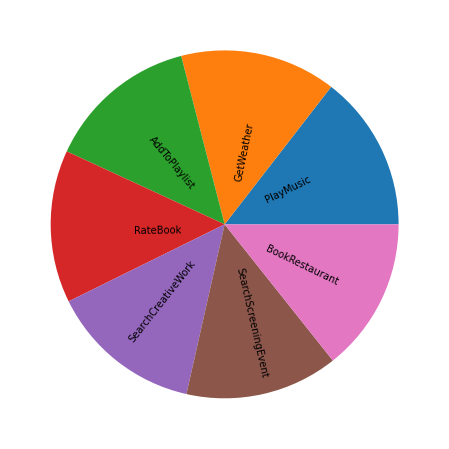

In [6]:
plt.figure(figsize=(8, 8))
#plt.hist(intent_counts, bins=intent_values)
plt.pie(intent_counts, labels=intent_values, labeldistance=0.25 ,rotatelabels=True)
plt.show()

**Define And Train The Model**

In [149]:
model = AutoComplete(2)
model.fit(train_data['query'][:2000], 1)

In [79]:
model._model_dict

{('<s>', '<s>'): {'play': 247,
  'is': 59,
  'will': 58,
  'add': 195,
  'rate': 142,
  'what': 186,
  'i': 205,
  'show': 72,
  'the': 19,
  "i'd": 39,
  'find': 165,
  "what's": 28,
  'book': 158,
  'please': 40,
  'can': 46,
  'give': 70,
  'table': 2,
  'how': 12,
  'out': 2,
  'weather': 6,
  'where': 38,
  'need': 4,
  'when': 16,
  'use': 6,
  'list': 3,
  'go': 1,
  'make': 9,
  'search': 14,
  'therese,': 1,
  'reserve': 3,
  'tell': 22,
  'for': 7,
  'turn': 1,
  'put': 22,
  'party': 1,
  'get': 5,
  'season': 1,
  'she': 3,
  'include': 1,
  "i'm": 8,
  'open': 6,
  'start': 2,
  'restaurant': 2,
  'bar': 1,
  'read': 1,
  'ethiopia': 1,
  'rat': 1,
  'look': 8,
  'this': 7,
  'want': 3,
  'stars': 1,
  'which': 5,
  'looking': 2,
  'forecast': 1,
  'during': 1,
  'diana': 1,
  'movie': 2,
  'download': 1,
  'forecase': 1,
  'listen': 3,
  'lets': 2,
  'programming': 1,
  'help': 1,
  'move': 1,
  'in': 1,
  "let's": 1,
  'there': 1,
  "how's": 2,
  'renee': 1,
  'on': 5,
 

In [150]:
print(model.pred_current_word('play the Instru'))

('play', 'the')
founded
['bistro', 'winter', 'it', 'top', 'song']


In [87]:
sant = "mora"
pred = []
while(True):
  pred = model.pred_next_word(sant)
  sant += ' ' + pred[0]
  sant = sant.strip()
  print(sant)
  if '</s>' in sant.split(' '):
    break

mora the
mora the the
mora the the gathering
mora the the gathering storm
mora the the gathering storm tv
mora the the gathering storm tv series
mora the the gathering storm tv series called
mora the the gathering storm tv series called the
mora the the gathering storm tv series called the golden
mora the the gathering storm tv series called the golden hits
mora the the gathering storm tv series called the golden hits of
mora the the gathering storm tv series called the golden hits of sandie
mora the the gathering storm tv series called the golden hits of sandie shaw
mora the the gathering storm tv series called the golden hits of sandie shaw .
mora the the gathering storm tv series called the golden hits of sandie shaw . </s>


In [91]:
model._model_dict.get(('tv', 'series'))

{'the': 1,
 '</s>': 1,
 'rat': 1,
 ',': 1,
 'krieg': 1,
 'of': 1,
 'effortless': 1,
 'lego': 1,
 'titled': 1,
 'to': 1,
 'called': 2}

In [82]:
model._vocabulary_dict

{'the': 1122,
 'a': 685,
 'in': 530,
 'for': 470,
 'to': 450,
 'of': 400,
 'at': 312,
 'i': 294,
 'play': 285,
 '.': 266,
 'book': 236,
 'is': 232,
 'add': 214,
 'what': 198,
 'find': 197,
 'my': 188,
 'on': 181,
 '6': 178,
 'me': 172,
 '?': 164,
 'rate': 162,
 'and': 157,
 'movie': 155,
 'from': 150,
 'this': 149,
 'playlist': 132,
 'weather': 129,
 'show': 121,
 'out': 121,
 'restaurant': 120,
 'be': 115,
 'by': 114,
 'give': 112,
 'will': 111,
 'want': 96,
 'can': 90,
 'stars': 85,
 'points': 85,
 'it': 83,
 'music': 80,
 'forecast': 79,
 'table': 77,
 'current': 75,
 'movies': 75,
 '': 75,
 'playing': 72,
 'like': 71,
 'need': 70,
 'album': 70,
 'song': 68,
 'that': 59,
 'reservation': 58,
 'one': 54,
 'called': 54,
 'schedule': 54,
 'are': 53,
 ',': 52,
 'now': 48,
 'playlist.': 47,
 'three': 47,
 'four': 46,
 'you': 45,
 'theatres': 45,
 'please': 44,
 'some': 43,
 '4': 43,
 'with': 43,
 'where': 41,
 '1': 41,
 "i'd": 41,
 '2': 40,
 '3': 40,
 'time': 39,
 'house': 39,
 'get': 37,

In [140]:
model._vocabulary_dict.get('instrumental')

1

In [124]:
AutoComplete.minimum_edit_distance('pla', '')

3

In [144]:
model._model_dict.get(('play','the'))

{'instrumental': 1,
 'playlist,': 1,
 'track': 6,
 'red': 1,
 'last': 5,
 'lure': 1,
 'song': 8,
 'album': 7,
 'top': 11,
 'garden': 1,
 'most': 1,
 'greatest': 4,
 'view': 1,
 'playlist': 1,
 'movie': 1,
 'newest': 3,
 'widow': 1,
 'game': 2,
 'theme': 1,
 'video': 1,
 'latest': 2,
 'tv': 1,
 'galway': 1,
 'great': 1,
 'what': 1,
 'ocelot': 1,
 'music': 1,
 'top-twenty': 1,
 'fool': 1}